## Imports

In [82]:
from sklearn.model_selection import train_test_split , ShuffleSplit
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import xgboost as xgb
from xgboost import plot_importance

import pandas as pd
import numpy as np
import random

import backtrader as bt

import matplotlib.pyplot as plt

import tabulate


## Data loading from CSV
### Stockdata
* Load data from CSV

In [83]:
stock_list = pd.read_csv('csv/result_table.csv',sep=',')
u_symbol = stock_list['SYMBOL'].unique()
date = pd.Series(stock_list['Date'])
stock_list.drop(['Date'],axis=1,inplace=True)
stock_list['date'] = date.apply(lambda x: np.datetime64(x))

stock_list

,SYMBOL,1Day,1Week,1Month,3Months,6Months,1Year,2Years,Day1Prior,Day2Prior,...,Month1Prior,Month2Prior,Month3Prior,Month4Prior,Month5Prior,Month6Prior,Month7Prior,Year1Prior,Year2Prior,date
0,ALT,-0.006659,-0.087680,NaN,NaN,NaN,NaN,NaN,0.065012,-0.133654,...,-0.249167,0.174707,2.817797,2.412879,2.085616,2.312500,1.815625,-0.272213,0.202937,2024-02-14
1,JOBY,0.008170,0.024510,-0.151961,0.004902,NaN,NaN,NaN,-0.067073,-0.055556,...,-0.159341,-0.202086,-0.420455,-0.216389,0.313305,0.481840,0.614776,0.478261,-0.322259,2023-10-11
2,TLRY,0.004065,-0.024390,-0.223577,-0.195122,NaN,NaN,NaN,-0.039062,-0.160410,...,-0.068182,0.464286,0.556962,-0.027668,0.069565,-0.075188,-0.115108,-0.236025,-0.797864,2023-09-19
3,CVNA,-0.004679,0.000425,0.602722,1.161208,0.680136,NaN,NaN,0.105833,0.232826,...,1.239048,1.620959,2.334752,1.133394,2.349003,3.867495,1.367573,0.117927,-0.914403,2023-06-13
4,UEC,0.007092,0.056738,-0.106383,0.209220,0.914894,NaN,NaN,0.032967,0.032967,...,-0.203390,-0.286076,-0.255937,-0.267532,-0.331754,-0.124224,-0.369128,-0.422131,-0.075410,2023-03-27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,CCRC,-0.002417,-0.016116,-0.033038,-0.140210,-0.103143,-0.157937,-0.629331,0.001614,0.044613,...,0.035893,0.299476,0.453162,0.411832,-0.376068,-0.328100,-0.250151,-0.108477,-0.119233,2018-11-15
444,SRNEQ,0.119565,0.195652,0.369565,0.543478,-0.032609,0.039130,-0.606522,-0.269841,-0.342857,...,-0.480226,-0.406452,0.260274,1.044444,0.862348,1.628571,1.555556,0.150000,-0.065041,2018-03-28
445,MARK,-0.056402,0.292683,0.350610,-0.076220,-0.376524,-0.696646,-0.914634,-0.056115,-0.290811,...,-0.497318,-0.257919,0.935103,1.122977,1.411765,1.385455,1.095847,1.030960,0.623762,2018-02-07
446,IPO.L,-0.044976,-0.031098,-0.065756,-0.294122,-0.108625,-0.241517,-0.507230,-0.003475,-0.003475,...,0.039580,0.010499,0.151426,0.075150,0.004892,0.078351,0.010499,-0.085454,-0.324780,2017-12-18


In [84]:
non_test_variables = ['SYMBOL','1Day','1Week','1Month','3Months','6Months','1Year','2Years','date']
predict_variables = ['1Day','1Week','1Month','3Months','6Months','1Year','2Years']

print("Number of rows before elimination of NaN: {0}".format(len(stock_list)))
stock_list_2y = stock_list.dropna(subset=["2Years"])
print("Number of rows after elimination of NaN only in 2Years: {0}".format(len(stock_list_2y)))
stock_list_2y = stock_list_2y.dropna(subset=non_test_variables)
print("Number of rows after elimination of NaN only in 2Years and other: {0}".format(len(stock_list_2y)))
stock_list_dropna = stock_list.dropna()
print("Number of rows after elimination of NaN: {0}".format(len(stock_list_dropna)))

Number of rows before elimination of NaN: 448
Number of rows after elimination of NaN only in 2Years: 337
Number of rows after elimination of NaN only in 2Years and other: 297
Number of rows after elimination of NaN: 219


## Create Testsplit
* We create a testsplit at a certain date which allows for roughly 70% of the data to be before it for training.
* We sort the data before hand and then split it such is guranteed that we dont have future data in our training data. 
* The other 30% will be after the date, we ensure this way that when we do out of sample testing that the training wasnt
"poisoned" with future data.

In [85]:
# We dont shuffle the array to prevent having future data in training set. 
sorted_stock_list = stock_list_dropna.sort_values(['date'], ascending= True)
train, test = train_test_split(sorted_stock_list, test_size=0.3, shuffle = False)
# Making sure we got no overlap
print("First date of \033[92mtraining\033[0m data: {0}".format(train['date'].iloc[0]))
print("Last date of \033[92mtraining\033[0m data:  {0}".format(train['date'].iloc[-1]))
print("First date of \x1b[31mtest\x1b[0m data:     {0}".format(test['date'].iloc[0]))
print("Last date of \x1b[31mtest\x1b[0m data:      {0}".format(test['date'].iloc[-1]))

First date of training data: 2013-03-06 00:00:00
Last date of training data:  2020-04-13 00:00:00
First date of test data:     2020-04-20 00:00:00
Last date of test data:      2022-02-22 00:00:00


In [86]:
x_train = np.array(train.drop(non_test_variables,axis=1))
y_train = {}
for variable in predict_variables:
    y_train[variable] = np.array(train[variable])

x_test = np.array(test.drop(non_test_variables,axis=1))
y_test ={}
for variable in predict_variables:
    y_test[variable] = np.array(test[variable])

## Train

In [87]:
regressors = {}
for variable in predict_variables: 
    # Define classifier
    clf = xgb.XGBRegressor()
    # Train on trainsplit
    clf.fit(x_train,y_train[variable])
    regressors[variable] = clf

## Predict In and Out-sample

In [88]:
# predict insample
for variable in predict_variables: 
    y_pred_insample = regressors[variable].predict(x_train)
    mse = mean_squared_error(y_pred_insample, y_train[variable])
    print("Mean squared error insample for variable:{0} = {1}".format(variable, mse))

print('\n')

# predict outsample
outsample_predictions = {}
for variable in predict_variables: 
    y_pred_outsample = regressors[variable].predict(x_test)
    y_base_truth = y_test[variable]
    outsample_predictions[variable] = y_pred_outsample
    mse = mean_squared_error(y_pred_outsample, y_test[variable])
    print("Mean squared error outsample for variable:{0} = {1}".format(variable, mse))
#%TODO strategie und plot fixen
#%TODO Strategie auf dem schreiben und testen

Mean squared error insample for variable:1Day = 4.491212769296104e-07
Mean squared error insample for variable:1Week = 4.665050840178514e-07
Mean squared error insample for variable:1Month = 6.503464958102985e-07
Mean squared error insample for variable:3Months = 4.0961305602188267e-07
Mean squared error insample for variable:6Months = 5.072709228725423e-07
Mean squared error insample for variable:1Year = 5.103545884450179e-07
Mean squared error insample for variable:2Years = 4.165293554170763e-07


Mean squared error outsample for variable:1Day = 0.021286599254714527
Mean squared error outsample for variable:1Week = 0.18266732159883128
Mean squared error outsample for variable:1Month = 0.253034759299379
Mean squared error outsample for variable:3Months = 2.2119059807610677
Mean squared error outsample for variable:6Months = 2.2031007145873676
Mean squared error outsample for variable:1Year = 7.291216380824999
Mean squared error outsample for variable:2Years = 6.992501891216496


## Predict direction
* We are testing if even tho the MSE isn't that great, we can at least predict the direction accuratly
* 1 represents falling 0 is rising

In [89]:
def classifier(x):
    if( x >= 0 ):
        return 0
    else:
        return 1

for variable in predict_variables: 
    classified_predictions = np.array(list(map(classifier, outsample_predictions[variable])))
    classified_y = np.array(list(map(classifier, y_test[variable])))
    print("Accuracy for {0} :".format(variable),metrics.accuracy_score(classified_y,classified_predictions))
    print("Precision for {0} :".format(variable),metrics.precision_score(classified_y, classified_predictions,average="macro"))
    print("Recall for {0} :".format(variable),metrics.recall_score(classified_y, classified_predictions,average="macro"))

# TODO check if 1year and 2year predictions are equally accurate for one stock

Accuracy for 1Day : 0.45454545454545453
Precision for 1Day : 0.4642857142857143
Recall for 1Day : 0.4666666666666667
Accuracy for 1Week : 0.5151515151515151
Precision for 1Week : 0.5188940092165899
Recall for 1Week : 0.5191053122087605
Accuracy for 1Month : 0.3939393939393939
Precision for 1Month : 0.3977272727272727
Recall for 1Month : 0.4083333333333333
Accuracy for 3Months : 0.45454545454545453
Precision for 3Months : 0.4532608695652174
Recall for 3Months : 0.46047794117647056
Accuracy for 6Months : 0.3939393939393939
Precision for 6Months : 0.3795121951219512
Recall for 6Months : 0.38617511520737324
Accuracy for 1Year : 0.5454545454545454
Precision for 1Year : 0.5356125356125356
Recall for 1Year : 0.5349487418452936
Accuracy for 2Years : 0.6515151515151515
Precision for 2Years : 0.5790243902439025
Recall for 2Years : 0.625


## Calculate possible returns
* Assuming we enter the market 1 Day after the short selling repport and either short or go long depending on the predictions over two years. 

In [90]:
# Data for the broker
clean_data = pd.read_csv('clean_data.csv',sep=',')
u_symbol = clean_data['symbol'].unique()
date = pd.Series(clean_data['datetime'])
clean_data.drop(['datetime'],axis=1,inplace=True)
clean_data['date'] = date.apply(lambda x: np.datetime64(x))

stock_data = {}
for symbol in u_symbol:
    stock_data[symbol] = clean_data[clean_data['symbol'] == symbol]

stock_data[list(stock_data.keys())[0]]

,open,high,low,close,volume,symbol,log_returns,date
0,32.30,33.58,32.30,32.84,7315000.0,1179.HK,0.056371,2020-09-23
1,34.08,34.20,33.50,33.73,2797160.0,1179.HK,0.026740,2020-09-24
2,33.12,33.12,32.30,32.62,3964430.0,1179.HK,-0.033462,2020-09-25
3,32.68,33.22,32.68,33.08,763500.0,1179.HK,0.014003,2020-09-28
4,33.58,34.18,33.58,33.99,2398130.0,1179.HK,0.027137,2020-09-29
...,...,...,...,...,...,...,...,...
838,29.20,29.20,28.30,28.85,2695218.0,1179.HK,-0.012059,2024-02-22
839,29.10,30.05,29.10,29.70,1548300.0,1179.HK,0.029037,2024-02-23
840,30.35,31.00,30.30,30.40,3111600.0,1179.HK,0.023296,2024-02-26
841,29.60,30.10,29.15,29.95,2316600.0,1179.HK,-0.014913,2024-02-27


In [91]:
# Method to find nearest date to a given pivot
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

# Trade simulation with short and long
* Trade function takes a dataset and a regressor and then simulates a simple trading strategy
* Trading strategy consists of:
    * If the regressor predicts a rise it will go long over the period
    * If the regressor predicts a fall it will go short over the period

In [92]:
def trade_long_and_short(test, regressor= regressors['2Years'], rnd=False):
    returns = {}
    for index, row in test.iterrows():
        prediction = 0
        if(rnd):
            prediction = random.randint(-1,1)
        else:
            x = np.array(test[test['SYMBOL'] == row['SYMBOL']].drop(non_test_variables, axis=1))
            prediction = regressor.predict(x)[0]
        # print(f"prediction 2 Years for stock{row['SYMBOL']} : {prediction_2y}")

        df = stock_data[row['SYMBOL']]
        buy_data = df[df['date'] == row['date']]
        entry_price = (buy_data['high'].values[0] + buy_data['low'].values[0])/2

        sell_date = row['date'] + np.timedelta64(730,'D')
        # Get the first date 2 years after entring the market
        sell_pivot = nearest(np.array(df['date']), sell_date)
        sell_data = df[df['date'] == sell_pivot]
        exit_price = (sell_data['high'].values[0] + sell_data['low'].values[0])/2

        profit = 0
        profit_percentage = 0
        result = {}
        if(prediction > 0):
            # long
            profit = exit_price - entry_price
            profit_percentage = profit/ entry_price * 100
        else:
            # short
            profit = entry_price - exit_price
            profit_percentage = profit/ entry_price * 100
            

        result['entry_price'] = entry_price
        result['exit_price'] = exit_price
        result['strategy'] = 'long' if prediction > 0 else 'short'
        result['profit'] = profit
        result['profit_percentage'] = profit_percentage
        returns[row['SYMBOL']] = result
    return(returns)

In [93]:
# Trade with regresor
returns_xgb = trade_long_and_short(test)

### Evaluate Trading
* Compare cumulated profit of random trading with regressor
* Take the average of 100 random runs to have a reliable comparison

In [94]:
def evalute_overall_profit(df):
    total = 0
    positive_trades = 0
    negative_trades = 0
    long_trades = 0
    short_trades = 0 
    profit_long = 0
    profit_short = 0
    total_trades = 0
    for symbol in df: 
        total = total + df[symbol]['profit_percentage']
        if df[symbol]['profit_percentage'] > 0:
            positive_trades += 1
        else:
            negative_trades += 1
    
        if df[symbol]['strategy'] == 'long':
            long_trades += 1
            profit_long += df[symbol]['profit_percentage']
        else:
            short_trades += 1
            profit_short += df[symbol]['profit_percentage']
        total_trades += 1

        

    return({'total': total, 'positive_trades':positive_trades, 'negative_trades':negative_trades, 
            'long_trades':long_trades, 'short_trades': short_trades,
            'profit_long': profit_long, 'profit_short': profit_short,
            'total_trades': total_trades})

In [95]:
# Run random trading 100 times to get the average profit
avg_profit_rnd = 0
runs = 100
for i in range(runs):
    avg_profit_rnd += evalute_overall_profit(trade_long_and_short(test,rnd = True))['total']
avg_profit_rnd = avg_profit_rnd / runs

# run on xgb
xgb_res = list(evalute_overall_profit(returns_xgb).values()) 


print("Random average profit: \033[91m{0}%\033[0m ".format(round(avg_profit_rnd,1)))
print("XGB profit: \033[92m{0}%\033[0m \nXGB postive trades: \033[92m{1}\033[0m\nXGB negative trades: \033[92m{2}\033[0m".format(round(xgb_res[0],1),xgb_res[1],xgb_res[2]))
print("XGB amount of long trades: \033[92m{0}\033[0m\nXGB amount of short trades: \033[92m{1}\033[0m".format(xgb_res[3],xgb_res[4]))
print("XGB profit long trades: \033[92m{0}\033[0m\nXGB profit short trades: \033[92m{1}\033[0m".format(round(xgb_res[5],1),round(xgb_res[6],1)))

Random average profit: 939.4% 
XGB profit: 1096.7% 
XGB postive trades: 41
XGB negative trades: 21
XGB amount of long trades: 24
XGB amount of short trades: 38
XGB profit long trades: -775.5
XGB profit short trades: 1872.2


# Train and test only on 2Years
* Train a regressor on a larger dataset where we only drop rows that have a NaN value in the 2Y 

## Create Testsplit

In [96]:
sorted_stock_list = stock_list_2y.sort_values(['date'], ascending = True)
train_2y, test_2y = train_test_split(sorted_stock_list, test_size=0.3, shuffle = False)
# Making sure we got no overlap
print("First date of \033[92mtraining\033[0m data: {0}".format(train['date'].iloc[0]))
print("Last date of \033[92mtraining\033[0m data:  {0}".format(train['date'].iloc[-1]))
print("First date of \x1b[31mtest\x1b[0m data:     {0}".format(test['date'].iloc[0]))
print("Last date of \x1b[31mtest\x1b[0m data:      {0}".format(test['date'].iloc[-1]))

First date of training data: 2013-03-06 00:00:00
Last date of training data:  2020-04-13 00:00:00
First date of test data:     2020-04-20 00:00:00
Last date of test data:      2022-02-22 00:00:00


In [97]:
x_train = np.array(train_2y.drop(non_test_variables,axis=1))
y_train = np.array(train_2y['2Years'])

x_test = np.array(test_2y.drop(non_test_variables,axis=1))
y_test = np.array(test_2y['2Years'])

## Train
* Train only on 2 Year dataset

In [98]:
# Define classifier
regressor_2y = xgb.XGBRegressor()
# Train on trainsplit
regressor_2y.fit(x_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Trade with new regressor

## Evaluate
* Evaluate performance of 2y Regressor

In [99]:
# Run random trading 100 times to get the average profit
avg_profit_rnd_2y = 0
# runs = 100
# for i in range(runs):
#     avg_profit_rnd += evalute_overall_profit(trade(test_2y,rnd = True))['total']
# avg_profit_rnd_2y = avg_profit_rnd / runs
# print("Random average profit: \033[91m{0}%\033[0m ".format(round(avg_profit_rnd_2y,1)))

returns_2y_reg = trade_long_and_short(test_2y, regressor=regressor_2y)
two_y_reg_ret = list(evalute_overall_profit(returns_2y_reg).values())


print("2y Regressor profit: \033[92m{0}%\033[0m \n2y Regressor postive trades: \033[92m{1}\033[0m\n2y Regressor negative trades: \033[92m{2}\033[0m".format(round(two_y_reg_ret[0],1),two_y_reg_ret[1],two_y_reg_ret[2]))
print("2y Regressor amount of long trades: \033[92m{0}\033[0m\n2y RegressorXGB amount of short trades: \033[92m{1}\033[0m".format(two_y_reg_ret[3],two_y_reg_ret[4]))
print("2y Regressor profit long trades: \033[92m{0}\033[0m\n2y Regressor profit short trades: \033[92m{1}\033[0m".format(round(two_y_reg_ret[5],1),round(two_y_reg_ret[6],1)))

2y Regressor profit: 158.9% 
2y Regressor postive trades: 44
2y Regressor negative trades: 43
2y Regressor amount of long trades: 46
2y RegressorXGB amount of short trades: 41
2y Regressor profit long trades: -2388.3
2y Regressor profit short trades: 2547.2


# Trade Simulation only short
* Trade function takes a dataset and a regressor and then simulates a simple trading strategy
* Trading strategy consists of:
    * If the regressor predicts a fall it will go short over the period

In [100]:
def trade_short(test, regressor= regressors['2Years'], rnd=False):
    returns = {}
    for index, row in test.iterrows():
        prediction = 0
        if(rnd):
            prediction = random.randint(-1,1)
        else:
            x = np.array(test[test['SYMBOL'] == row['SYMBOL']].drop(non_test_variables, axis=1))
            prediction = regressor.predict(x)[0]
        # print(f"prediction 2 Years for stock{row['SYMBOL']} : {prediction_2y}")

        df = stock_data[row['SYMBOL']]
        buy_data = df[df['date'] == row['date']]
        entry_price = (buy_data['high'].values[0] + buy_data['low'].values[0])/2

        sell_date = row['date'] + np.timedelta64(730,'D')
        # Get the first date 2 years after entring the market
        sell_pivot = nearest(np.array(df['date']), sell_date)
        sell_data = df[df['date'] == sell_pivot]
        exit_price = (sell_data['high'].values[0] + sell_data['low'].values[0])/2

        profit = 0
        profit_percentage = 0
        result = {}
        if(prediction < 0):
            # short
            profit = entry_price - exit_price
            profit_percentage = profit/ entry_price * 100
            
            

        result['entry_price'] = entry_price
        result['exit_price'] = exit_price
        result['strategy'] = 'short' if prediction < 0 else 'long'
        result['profit'] = profit
        result['profit_percentage'] = profit_percentage
        returns[row['SYMBOL']] = result
    return(returns)

In [116]:
# Run random trading 100 times to get the average profit
avg_profit_rnd_2y = 0
# runs = 100
# for i in range(runs):
#     avg_profit_rnd += evalute_overall_profit(trade(test_2y,rnd = True))['total']
# avg_profit_rnd_2y = avg_profit_rnd / runs
# print("Random average profit: \033[91m{0}%\033[0m ".format(round(avg_profit_rnd_2y,1)))

returns_2y_reg = trade_short(test_2y, regressor=regressor_2y)
two_y_reg_ret = list(evalute_overall_profit(returns_2y_reg).values())

print("2y Regressor profit: \033[92m{0}%\033[0m \n2y Regressor postive trades: \033[92m{1}\033[0m\n2y Regressor negative trades: \033[92m{2}\033[0m".format(round(two_y_reg_ret[0],1),two_y_reg_ret[1],two_y_reg_ret[4]-two_y_reg_ret[1]))
print("2y Regressor amount of short trades: \033[92m{0}\033[0m".format(two_y_reg_ret[4]))
print("2y Regressor skipped trades: \033[92m{0}\033[0m".format(two_y_reg_ret[7]-two_y_reg_ret[4]))
print("2y Regressor total possible trades: \033[92m{0}\033[0m".format(two_y_reg_ret[7]))
print("2y Regressor profit short trades: \033[92m{1}%\033[0m".format(round(two_y_reg_ret[5],1),round(two_y_reg_ret[6],1)))


2y Regressor profit: 2547.2% 
2y Regressor postive trades: 37
2y Regressor negative trades: 4
2y Regressor amount of short trades: 41
2y Regressor skipped trades: 46
2y Regressor total possible trades: 87
2y Regressor profit short trades: 2547.2%


<Axes: >

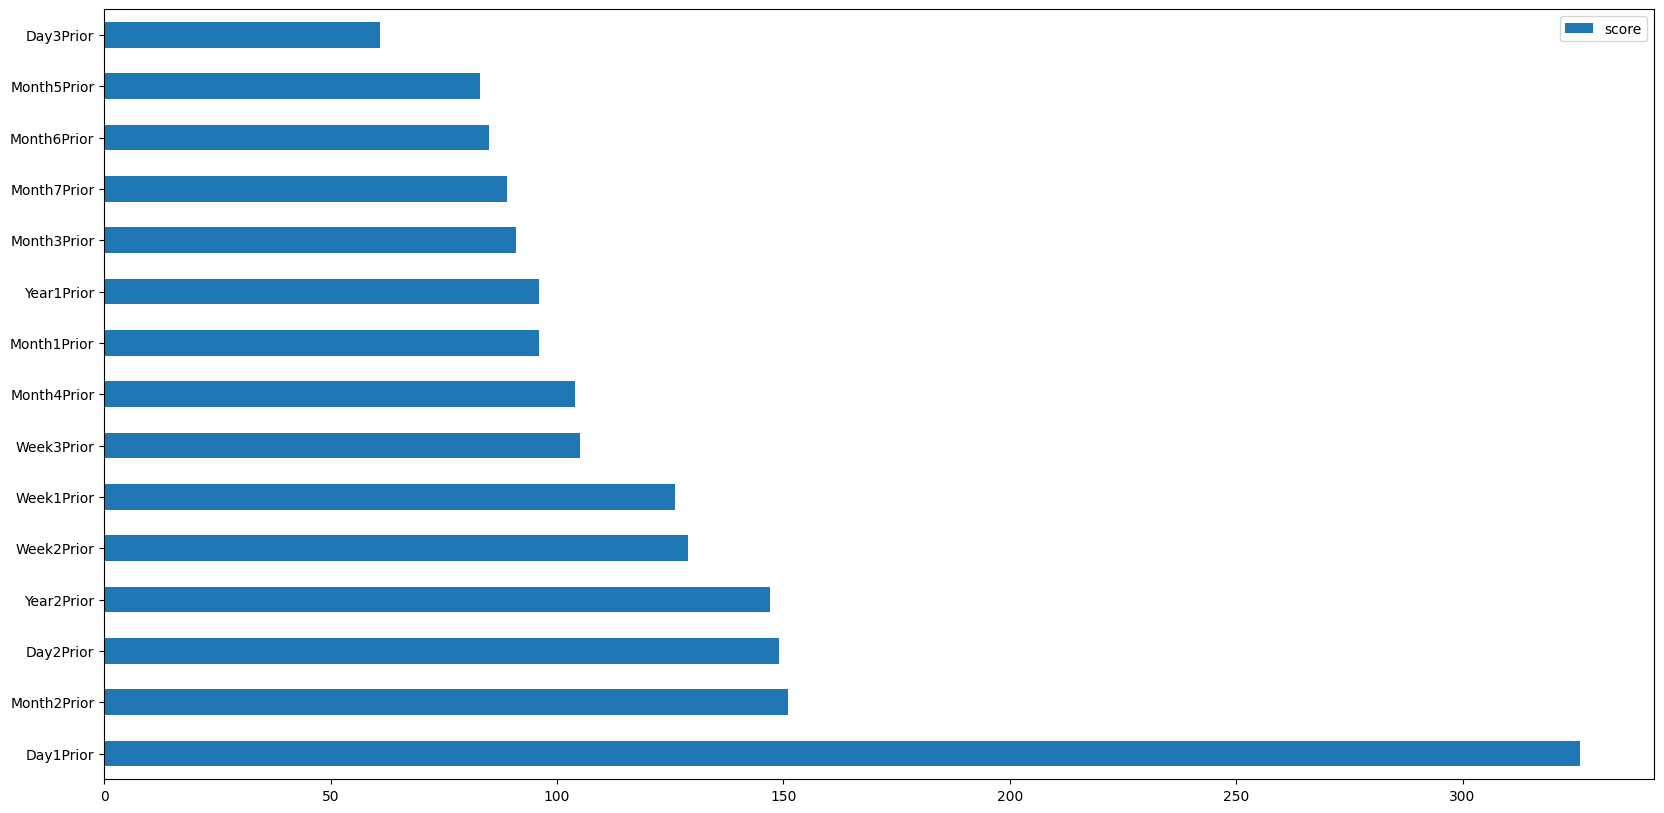

In [102]:
feature_important = regressor_2y.get_booster().get_score(importance_type='weight')

keys = list(feature_important.keys())
values = list(feature_important.values())

feature_names = train_2y.drop(non_test_variables,axis=1).columns.tolist()

data = pd.DataFrame(data=values, index=feature_names, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

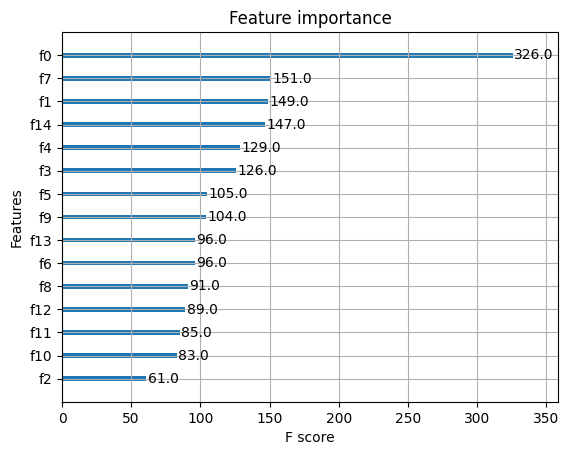

In [103]:
plot_importance(regressor_2y)